This notebook is intended to be an explanation of the segmentation process used to go from images generated by our model to grain maps which can be analysed. The goal is to go from an image with continuos pixel values to masks which isolate each grain.

In [1]:
import torch
import torch.nn as nn
import pandas as pd

import matplotlib.pyplot as plt

from apd_dataset_constructor import APDDataset
from image_processing import *

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [3]:
#First load in our datasets, the source dataset train_data, and the dataset generated by the model, gen_data

train_data = APDDataset(root='test_dataset', size=(64,64))
gen_data = APDDataset(root="gen_data", device='cpu')

In [4]:
gen_data.__getitem__(0).dtype

torch.uint8

The first goal of our analysis is to see how the pixel values are distributed across each image!

array([[<Axes: title={'center': '0'}>]], dtype=object)

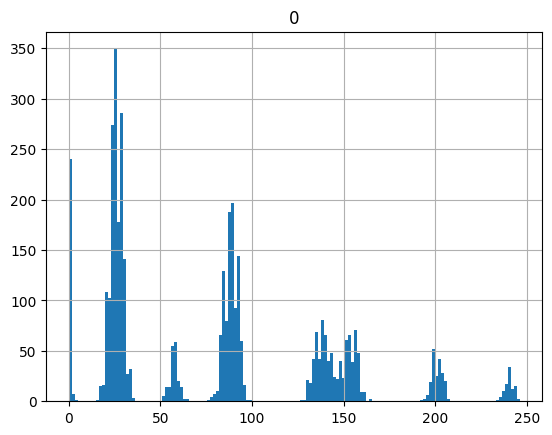

In [58]:
img1 = gen_data.__getitem__(0)
df = pd.DataFrame(img1.flatten())
df.hist(bins=150)

array([[<Axes: title={'center': '0'}>]], dtype=object)

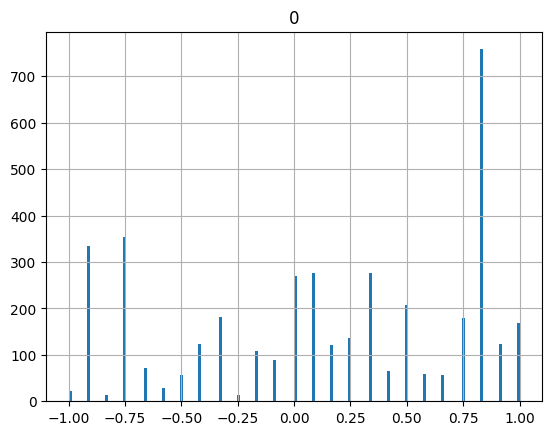

In [57]:
img2 = train_data.__getitem__(2)
df = pd.DataFrame(img2.flatten())
df.hist(bins=150)

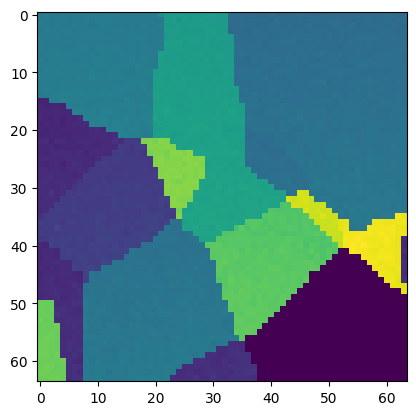

In [7]:
plt.imshow(img1.transpose(0,-1))

We want to process the images so that the grains can be easily identified. Approaches that spring to mind are the use of edge detection algorithms or by clustering points based on their brightness. From inspecting the histograms and the images themselves, it appears the model has done a much better job capturing the edges than the image-wide distribution of pixel intensities. Consequently using an edge-detection approach seems more sensible. First we will use a straightforward Sobel edge detection.

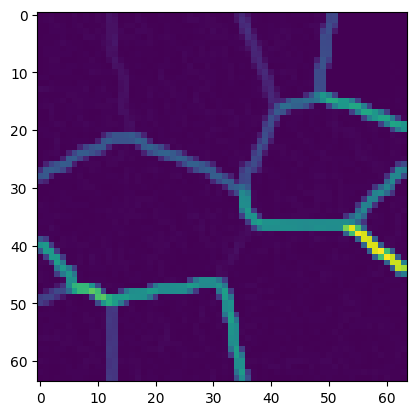

In [59]:
import cv2
import numpy as np
img = img1.transpose(0,-1).numpy()
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)  # Horizontal edges
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)  # Vertical edges
gradient_magnitude = cv2.magnitude(sobelx, sobely)

plt.imshow(gradient_magnitude)
plt.show()

We also have the option to smooth the image, which may help with finding true edges

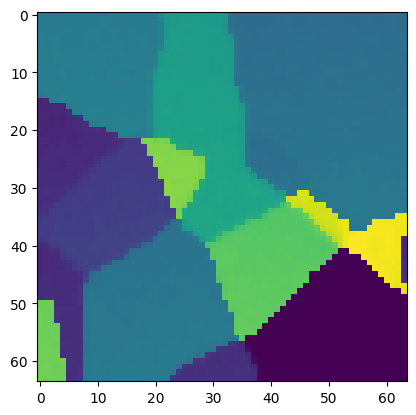

In [41]:
from medpy.filter.smoothing import anisotropic_diffusion

img_anis = anisotropic_diffusion(img)
img_anis = anisotropic_diffusion(img_anis)
plt.imshow(img_anis)

<class 'numpy.ndarray'>


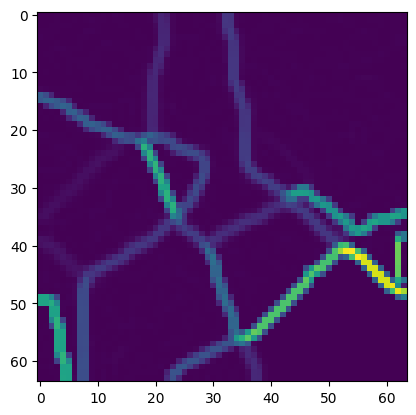

In [42]:
# Try sobel to img_anis:
sobelx = cv2.Sobel(img_anis, cv2.CV_64F, 1, 0, ksize=3)  # Horizontal edges
sobely = cv2.Sobel(img_anis, cv2.CV_64F, 0, 1, ksize=3)  # Vertical edges
 
# Compute gradient magnitude
gradient_magnitude = cv2.magnitude(sobelx, sobely)
 
# Convert to uint8
#gradient_magnitude = cv2.convertScaleAbs(gradient_magnitude)
print(type(gradient_magnitude))
# Display result
thres = 1
threshholded_sob = gradient_magnitude > thres
plt.imshow(gradient_magnitude)
plt.show()

We want to threshold our edge map to get a binary mask. From experimentation, a threshold of 26 obtained good results.

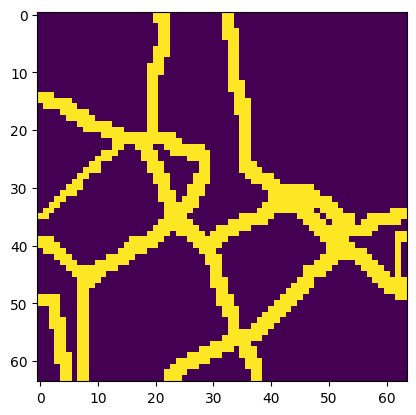

In [43]:
thres = 26
threshholded_sob = gradient_magnitude > thres
plt.imshow(threshholded_sob)
plt.show()


Take one of our edge maps (perhaps canny or clipped Sobel) and then define a distance function from this set. Take the local maxima of this function to be seeds in a watershed algorithm. Partition the image \ edges accordingly. Then each of the edge pixels is mapped by comparing it to its neighbours in the now segmented image - if it is close enough to some of its neighbours it is included into the the grain which is the best match. otherwise it could start a new grain.

Next we can define a distance function on the image defined as the distance to the set of edge points. This should hopefully provide us with regions corresponding to the image grains:

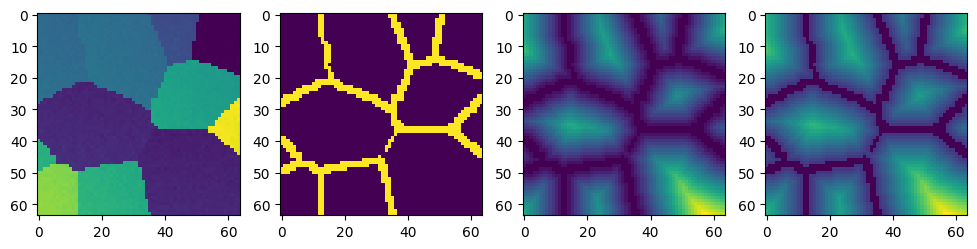

In [45]:
img = gen_data.__getitem__(0)
fig, axs = plt.subplots(1,4, figsize=(12,3))
axs[0].imshow(img.transpose(0,-1))
sob_img = Sobel_thres(img)
axs[1].imshow(sob_img)

sob_img = np.uint8(sob_img)
sob_img = 255 * (1 - sob_img)
dist = cv2.distanceTransform(sob_img, cv2.DIST_L2, maskSize=3)
axs[2].imshow(dist)

axs[3].imshow(dist + sob_img/100)
plt.show()

Now we seek to find all the local maxima:
First we smooth the distance map out to get rid of any maxima caused by tiny perturbations, and then we find the maxima of the smoothed image

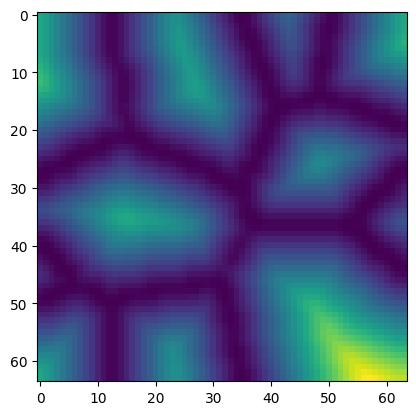

In [46]:
# Smooth
dist_anis = anisotropic_diffusion(anisotropic_diffusion(anisotropic_diffusion(dist)))
plt.imshow(dist_anis)

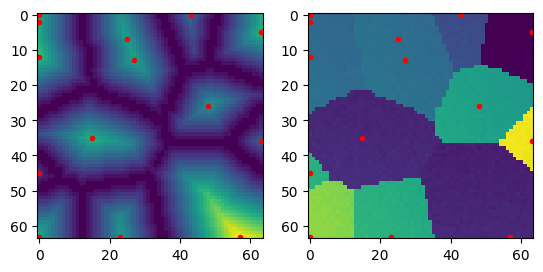

In [47]:
from skimage.feature import peak_local_max

padded_dist = cv2.copyMakeBorder(dist_anis, 5,5,5,5,borderType=cv2.BORDER_CONSTANT)
maxes = peak_local_max(image=dist)
maxes = peak_local_max(image=padded_dist, min_distance=2)
maxes = maxes - 5
fig, ax = plt.subplots(1,2)

ax[0].imshow(dist)
ax[0].plot(maxes[:,1], maxes[:,0], 'r.')

ax[1].imshow(img.transpose(0,-1).numpy())
ax[1].plot(maxes[:,1], maxes[:,0], 'r.')

plt.show()

This seems to be working quite well, however in some cases there is still more than one maximum per grain, which is not what we want. The idea is to eventually use watershed segmentation with each grain starting from a single seed. Thus we now look to group maxima in the same grain together/eliminate excess maxima so that there is only one per grain.

An initial idea is to take each pair of maxima and compare the average intensities in a little area around each. If their difference is close enough, we suspect they may be in the same grain. From this point we can then check along the straight line between them and see whether there is an edge here according to our edge intensity map. If there is an edge, then we may conclude that they were not really part of the same grain after all, but merely had similar intensities.

In [48]:
# Watershed approach: first define a function that returns the average intensity in a nbhd of a point

def mean_intensity(coord, img, radius=1):
    h, w = img.shape[0], img.shape[1]
    mean = 0
    n = 0
    for i in range(-radius,radius+1):
        for j in range(-radius,radius+1):
            x = coord[0] + i
            y = coord[1] + j
            if 0 <= x < h and 0 <= y < w:
                n += 1
                mean = ((n-1)*mean + img[x][y])/n
    return mean

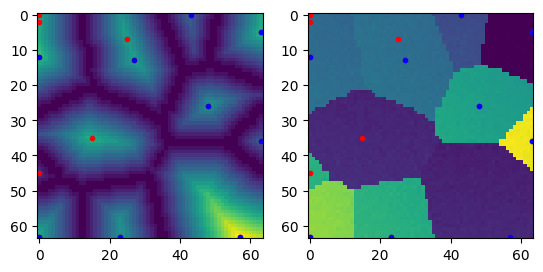

In [49]:
# We start by comparing the mean intensities around a point and then eliminating one if they are too close. We observe that this does get rid of most of the duplicate seeds, 
# but also gets rid of some we don't want it to, due to similar intensities appearing multiple times over different parts of the image.

destroy = []
intensity_thres = 3
for i in range(len(maxes)):
    for j in range(i+1, len(maxes)):
        max1 = maxes[i]
        max2 = maxes[j]
        if abs(mean_intensity(max1, img=img.transpose(0,-1).numpy()) - mean_intensity(max2, img=img.transpose(0,-1).numpy())) < intensity_thres:
            destroy.append(max2.tolist())

culled_maxes = np.array([max for max in maxes.tolist() if not(max in destroy)])
#print(culled_maxes)
fig, ax = plt.subplots(1,2)

ax[0].imshow(dist)
ax[0].plot(maxes[:,1],maxes[:,0], 'r.')
ax[0].plot(culled_maxes[:,1],culled_maxes[:,0], 'b.')

ax[1].imshow(img.transpose(0,-1).numpy())
ax[1].plot(maxes[:,1],maxes[:,0], 'r.')
ax[1].plot(culled_maxes[:,1],culled_maxes[:,0], 'b.')

# Note: in plots below, blue corresponds to a max that has been kept, while red corresponds to one that has been culled.

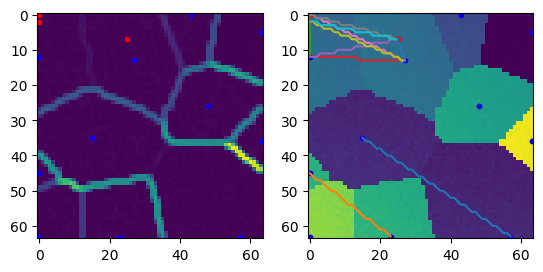

In [50]:
# We cull the points again, but now checking the edge intensity map for an edge between two points which we think may be duplicates.

sobelx = cv2.Sobel(img.transpose(0,-1).numpy(), cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(img.transpose(0,-1).numpy(), cv2.CV_64F, 0, 1, ksize=3)
gradient_magnitude = cv2.magnitude(sobelx, sobely)

sus_points = [] # This is to be a list of lists, where the ith element is the list of points further down the list than i which have similar intesity (so that we can evaluate them systematically later.)
intensity_thres = 5
for i in range(len(maxes)):
    sus_points.append([])
    for j in range(i+1, len(maxes)):
        max1 = maxes[i]
        max2 = maxes[j]
        if abs(mean_intensity(max1, img=img.transpose(0,-1).numpy()) - mean_intensity(max2, img=img.transpose(0,-1).numpy())) < intensity_thres:
            sus_points[i].append(max2.tolist())

# Next we want to check each of these candidate duplications and see if they cross an edge
from skimage.draw import line

p1, p2 = maxes[0],maxes[1]
l = np.asarray(line(p1[0],p1[1],p2[0],p2[1])).transpose()
l_flat = 64*l[:,0] + l[:,1]
img_flat = img.transpose(0,-1).numpy().flatten()
#print(l_flat.shape)
values = img_flat[l_flat]
#print(values.shape, '\n', values)



def edge_between(p1, p2, img, thres=500):
    l = np.array(line(p1[0],p1[1],p2[0],p2[1]))
    ncols = img.shape[1]
    #print(ncols)

    l_flat = ncols * l[0] + l[1]
    img_flat = img.flatten()

    values = img_flat[l_flat]
    #print(values)

    if values.max() > thres:
        return True
    else:
        return False
    
destroy = []
saved = []
lines = []
#print(f"sus_points = {sus_points}")
for i in range(len(maxes)):
    max1 = maxes[i]

    for max2 in sus_points[i]:
        lines.append(line(max1[0],max1[1],max2[0],max2[1]))
        if edge_between(max1, max2, gradient_magnitude, thres=20) == False and not(max2 in destroy):
            destroy.append(max2)

#print("destroy = ", destroy)


culled_maxes = np.array([max for max in maxes.tolist() if max not in destroy])
fig, ax = plt.subplots(1,2)
ax[0].imshow(gradient_magnitude)
ax[0].plot(maxes[:,1],maxes[:,0], 'r.')
ax[0].plot(culled_maxes[:,1],culled_maxes[:,0], 'b.')

ax[1].imshow(img.transpose(0,-1).numpy())
ax[1].plot(maxes[:,1],maxes[:,0], 'r.')
ax[1].plot(culled_maxes[:,1],culled_maxes[:,0], 'b.')

for l in lines:
    l = np.array(l)
    ax[1].plot(l[1], l[0])

plt.show()

We are now doing a much better job of identifying one seed point per grain, as the line checks have stopped us removing the seed points which were previously removed in error!
Finally we have a function to obtain a good set of seeds, so we can pass these to sci-kit image's watershed algorithm:

Text(0.5, 1.0, 'Segmented')

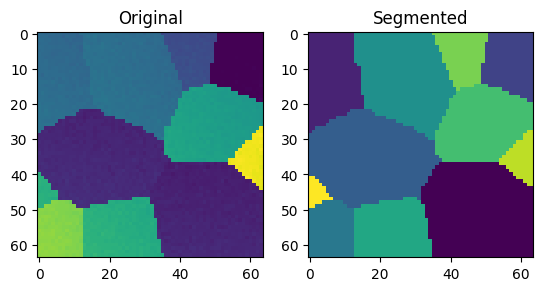

In [52]:
from skimage.segmentation import watershed

h, w = img.transpose(0,-1).numpy().shape[:2]
markers = np.zeros((h,w), dtype=np.int32)
for i in range(len(culled_maxes)):
    r, c = culled_maxes[i]
    markers[r][c] = 1 + i


segments = watershed(image=gradient_magnitude, markers=markers)

fig, axs = plt.subplots(1,2)
axs[0].imshow(img.transpose(0,-1).numpy())
axs[0].set_title("Original")
axs[1].imshow(segments)
axs[1].set_title("Segmented")

We see from the example that this segmentation process has produced a very accurate segmentation, and changing the image sampled from the dataset yields generally similar, satisfactory results. As such, this is the basis for the segmentation function written up in image_processing.py for use in analysis of the generated images.